In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/3-particle_sizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Example 3. Single particle sizing



## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

from deeptrack.extras import datasets
datasets.load('ParticleSizing')
experimental_data = np.load('datasets/ParticleSizing/sizing_150nm_227nm_PSL.npy', allow_pickle=True)

import scipy.io as IO

IMAGE_SIZE = 64

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Download Complete!
Extracting ParticleSizing...


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 64 by 64 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 100nm and 400nm, and a refractive index between 1.37 and 1.67. Its position in the camera plane is constrained to be within within two pixels of the image center, and is sampled with a normal distribution with standard deviation of 2 pixel units along the axis normal to the camera plane. 

In [3]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 2,
    radius=lambda:1e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.rand() * 0.3 + 1.37,
    L=8,
    position_unit="pixel",
)

We use a single wavelength brightifeld feature to calculate the field at the camera plane. We aberrate the image with a random coma, which was observed in the experimental data. Moreover, the pupil is cropped at high frequencies.

In [4]:
HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.5)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.5)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil= HC >> VC >> CROP
)

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:171: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 23.133858267716537 should be at most 0.5
To fix, set magnification to 47.0, and downsample the resulting image with dt.AveragePooling((47.0, 47.0, 1))

  warnings.warn(


The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [5]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: np.random.rand() * 0.02,
)

noise = real_noise >> dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.03j,
    real_sigma=real_noise.sigma
)

def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [6]:
dataset = optics(particle >> noise) >> complex_to_float

### 2.2 Defining the training label

We extract the parameters we want the network to learn. We also rescale them such that they have a similar size.

In [7]:
def get_label(image):
    px = np.array(image.get_property("position")) - IMAGE_SIZE / 2
    z = image.get_property("z") * 0.1
    r = image.get_property("radius") / 1e-6
    n = image.get_property("refractive_index") - 1.33
    return np.array([r * 10, n * 10])

# 2.3 Visualizing the dataset

We resolve and show 16 images

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:272: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


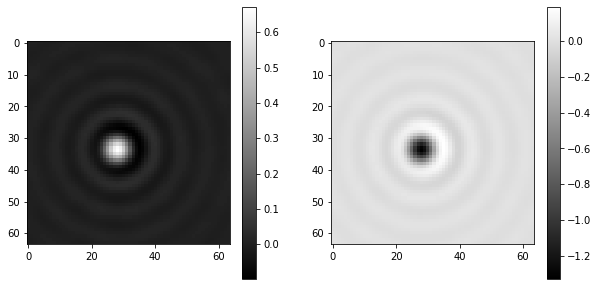

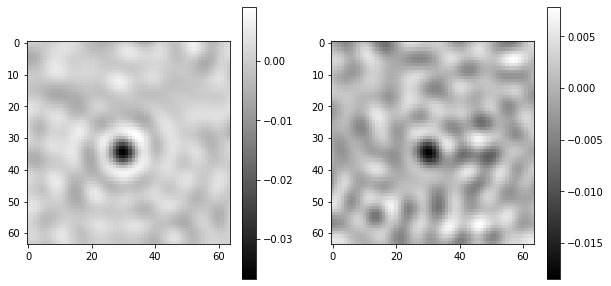

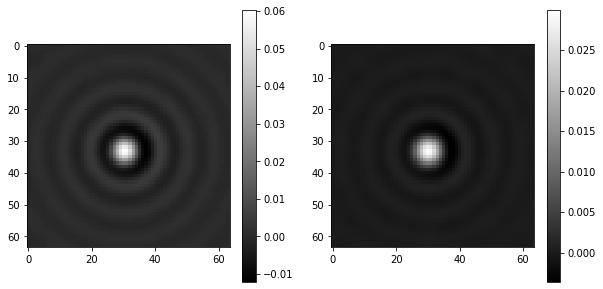

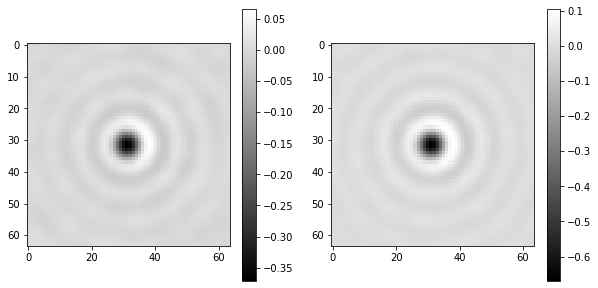

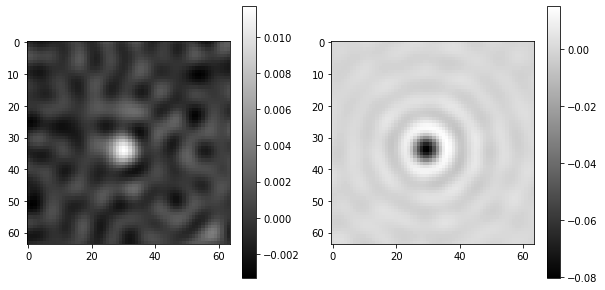

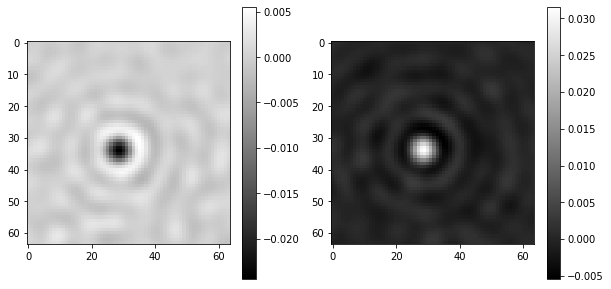

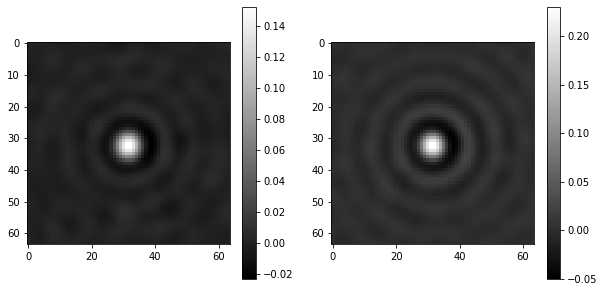

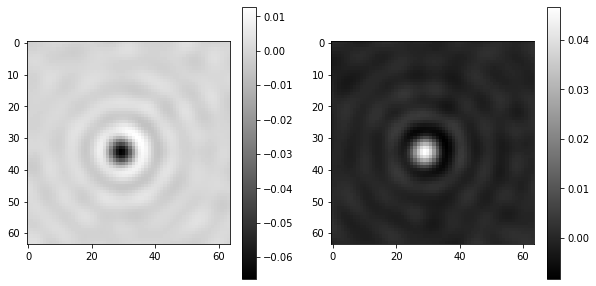

In [8]:
## NUMBER_OF_IMAGES = 16

for i in range(8):
    dataset.update()
    image_of_particle = dataset.resolve()

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image_of_particle[:, :, 0], cmap="gray")
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(image_of_particle[:, :, 1], cmap="gray")
    plt.colorbar()
    plt.show()


## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [9]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions=(32, 64, 128),
    dense_layers_dimensions=(64, 64),
    steps_per_pooling=2,
    number_of_outputs=2,
    dropout=(.2, .2),
    loss="mae",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu")
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        608       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 32)       0         
 ropout2D)                                                       
                                                             

## 4. Training the network

We use the `ContinuousGenerator` to generate the images. It creates a new thread and generates images while the model is training. 

Set TRAIN_MODEL to True to train the model, otherwise a pretrained model is downloaded.

Generating 2009 / 2000 samples before starting training
Epoch 1/100
31/31 [==============================] - 4s 18ms/step - loss: 0.8815 - val_loss: 0.5950
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5773 - val_loss: 0.5481
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5761 - val_loss: 0.5358
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5635 - val_loss: 0.5392
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5547 - val_loss: 0.5305
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5409 - val_loss: 0.5485
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5339 - val_loss: 0.4989
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5282 - val_loss: 0.4923
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5099 - val_loss: 0.5271
Epoch 10/100
31/31 [========================

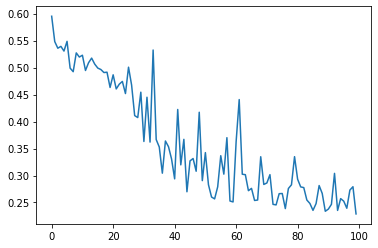

In [10]:
TRAIN_MODEL = True

validation_set_size = 256
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset & (dataset >> get_label),
        min_data_size=int(2e3),
        max_data_size=int(2e4),
        batch_size=64,
        max_epochs_per_sample=33
    )

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=100,
        )
    
    plt.plot(h.history["val_loss"])
    
else:
    model_path = datasets.load_model("ParticleSizing")
    model.load_weights(model_path)

## 5. Evaluating the network

We show the the error as a function of some properties.

8/8 [==============================] - 0s 2ms/step


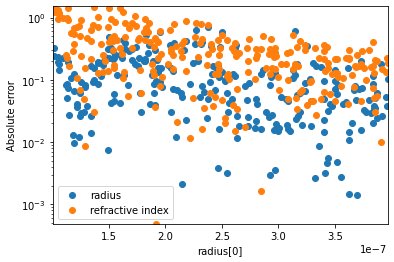

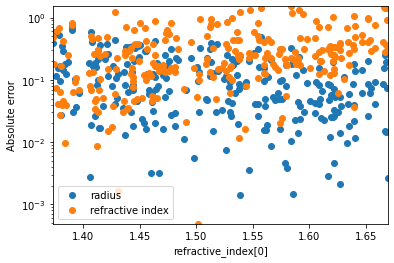

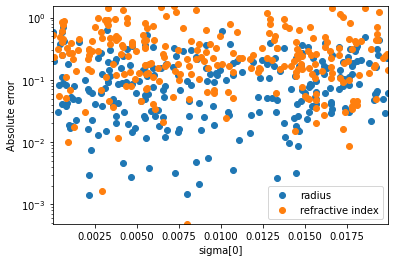

In [11]:
properties = ["radius", "refractive_index", "sigma"]

validation_prediction = model.predict(np.array(validation_set))

validation_errors = [
    np.abs(validation_prediction[:, idx] - np.array(validation_labels)[:, idx]) for idx in range(2)
]

error_names = ["radius", "refractive index"]

for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
    
    for col in range(property_values.shape[1]):
        values = property_values[:, col]

        plt.subplot(1, property_values.shape[1], col + 1)
        for validation_error in validation_errors:
            plt.scatter(values, validation_error, alpha=1)
        plt.xlim([np.min(values), np.max(values)])
        plt.ylim([np.min(validation_error), np.max(validation_error)])
        plt.yscale("log")
        plt.ylabel("Absolute error")
        plt.xlabel("{0}[{1}]".format(property_name, col))
        
    plt.legend(error_names)

    
    plt.show()

We estimate the size of particles using experimentally captured images. The particles were traced, so we display the average size and refractive index measured by the model over the trace.

6/6 [==============================] - 0s 3ms/step
2.9173846


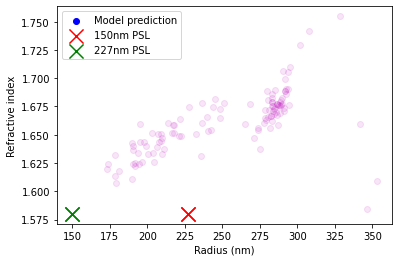

In [12]:
predictions = np.array([
        np.mean(
            model.predict(
                np.array(experimental_data[idx])
            ),
            axis=0
        ) for idx in range(len(experimental_data))
])

print(np.mean(predictions))
plt.scatter([],[], c='b', alpha=1)
plt.scatter(0.227 * 1000, 1.58, marker='x', s=200, c='r')
plt.scatter(0.15 * 1000, 1.58, marker='x', s=200, c='g')

plt.scatter(predictions[:, 0] * 100, predictions[:, 1] / 10 + 1.33, c='m', alpha=0.1)
plt.scatter(0.227 * 1000, 1.58, marker='x', s=200, c='r')
plt.scatter(0.15 * 1000, 1.58, marker='x', s=200, c='g')


plt.legend(["Model prediction", "150nm PSL", "227nm PSL"])
# plt.axis([100, 300, 1.4, 1.7])
plt.xlabel('Radius (nm)')
plt.ylabel('Refractive index')
plt.show()